# Image recognition of Anderson states

## Preliminaries

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import torch
torch.__version__
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#!pip install torch=='1.7.0'
#!pip install torchvision=='0.7.0'
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.8.1+cu101
1.7.0+cu101


In [40]:
import random

In [41]:
#!pip install fastai==1.0.61
import fastai
from fastai.collab import *
#!pip install --upgrade fastai
#!pip uninstall fastai -y
print(fastai.__version__)
from fastai.vision import *


1.0.61


In [42]:
#bs = 64
bs = 16  # uncomment this line if you run out of memory even after clicking Kernel->Restart
myepoch0 = 4
myepoch1 = 2
myepoch2 = 2

## Reading in the image data

In [23]:
from google.colab import files
uploaded = files.upload()

Saving W15.0-10data.csv to W15.0-10data (2).csv


In [43]:
def to_list(list):
  py_list = []
  for i in list:
    py_list.append(float(i))
  return py_list

In [44]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay].append(float(line))
        #print(float(line))
        col += 1
    return system
        

In [6]:
import os

data   = []
labels = []

datasrc = '/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs' #Source of the locations of the data

disorder_systems      = []
disorder_class_labels = []

for disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...
    print(disorder_class_folder.path)
    disorder_class = disorder_class_folder.path.rsplit('_',1)[1]
    print(disorder_class)
    disorder_systems.append([])
    disorder_class_labels.append(disorder_class)
    
    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...
        #print(file)                                             #...
        the_file = open(file.path, 'r')                          #...open the file to read the locations of the data...
        
        number_of_data = 0
        for line in the_file:                                    #...for each... 
            
            if (number_of_data < 1):                           #...gather a certain amount of data...
                print(" ")
                number_of_data += 1

                #print(line)
                line = line.rsplit('\n',1)[0]
                raw_data = open(line,'r')
                system = make_3D_structure(raw_data, 20)
                #print(system)
                disorder_systems[-1].append(system)
                print("added system to " + disorder_class_labels[-1])
     


FileNotFoundError: ignored

In [45]:
class ThreeDDataset(Dataset):
    def __init__(self, x):
        self.x = []
        self.y = []
        class_ind = 0
        for dis_class in x:
          for item in dis_class:
            self.x.append(item)
            self.y.append(class_ind)
          class_ind+=1
        self.c = len(self.x)

        t = True
        for dis_class in self.x:
          t = t and len(dis_class)==0
        self.is_empty=t
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]
        

In [78]:
import pandas as pd
import io

tensors = []  #Each list in this list is a seperate label list
n_labels = len(uploaded) #Defined by the above list
print("Number of classes: ", n_labels)

labels = []
for class_file in uploaded:
  """
  Add new class-;ost to the tesnsors list, read the systems one by one out 
  of the data file then add that data to the correct class list in tensors
  and add the name of the disorder class to the labels list   
  """
  tensors.append([])
  print(class_file)
  disorder_class = class_file.rsplit('-',1)[0]
  print(disorder_class)
  labels.append(disorder_class)

  df = pd.read_csv(io.BytesIO(uploaded[class_file]))
  print("Number of systems: ", len(df.transpose())-1)
  for i in range(len(df.transpose())-1):
    print(to_list(df[str(i)]))
    tensors[-1].append(to_list(df[str(i)]))
  
print(tensors)
print(labels)


#for i in range(n_labels):
  #print(i+1)
  #print(tensors[i])

loader = ThreeDDataset(tensors)
#databunch = DataBunch.create(loader, loader, bs=2, num_workers=1)

Number of classes:  1
W15.0-10data.csv
W15.0
Number of systems:  10
[0.007745588294469487, -0.006775368703466595, 0.013036014743656586, -0.0030020590387616264, -0.0024367760194735463, 0.007955112275576295, 0.001975134084046208, 0.0009243249967486273, -0.0016525691056084384, -0.04855855302065434, -0.005725354295427918, 0.02933006481837332, 0.00570153497132396, -0.0002613223265101868, -0.0003776845282855976, -0.0018462916055095922, -0.011997301967605343, -0.021971794880018485, 0.02150441819260375, 0.01858214233033984, -0.03889669660968588, 0.01955456580319988, 0.003912945790670808, 0.0020213469889822947, 0.003217782160804053, -0.002181321201319897, -0.02267347928374406, -0.004179033578070059, 0.04575755627357109, 0.0009324377018686717, 0.011226535370751049, 0.0639813705412819, 0.015017493875076981, -0.005592540521971453, 0.0024110253395152647, -0.002910802449091447, -0.01447159637830626, 0.10621155187429043, 0.09550294889778804, 0.01427410945813722, 0.05664132387411942, 0.047486948515777

## Train model

In [30]:
learn = cnn_learner(databunch, models.resnet50, metrics=error_rate, pretrained=False)#.to_fp16()

In [ ]:
learn.model

In [ ]:
print(learn.summary())

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


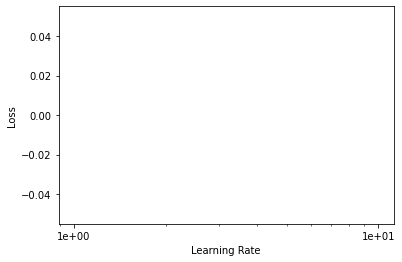

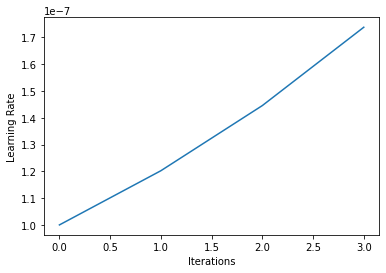

In [33]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

In [34]:
lr=1.e-2

In [35]:
learn.fit_one_cycle(myepoch0,lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.273160,-0.180201,0.900000,00:04
1,-0.033539,-0.269813,0.900000,00:04
2,0.258895,-0.699661,0.800000,00:04
3,0.017392,-0.661022,0.900000,00:04


In [36]:
learn.save('stage-0')

In [37]:
learn.show_results()

AttributeError: ignored

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


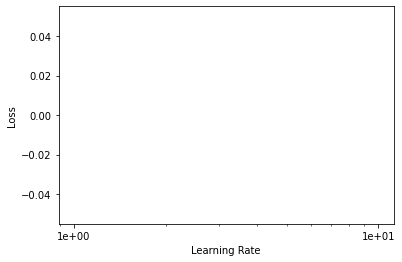

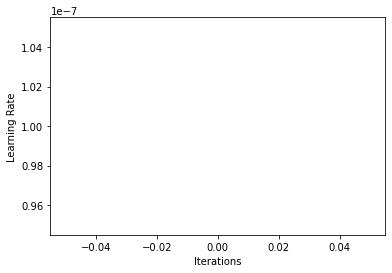

In [39]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

## Heatmap

In [ ]:
idx=0
x,y = loader.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## refining the model - stage 1

In [ ]:
learn.load('stage-0');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
#learn.recorder.plot_losses()
# learn.recorder.plot_lr()

In [ ]:
learn.fit_one_cycle(myepoch1, max_lr=slice(3e-6,3e-4))

In [ ]:
learn.save('stage-1')

## refining the model further - stage 2

In [ ]:
learn.load('stage-1');
learn.unfreeze();
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(myepoch2, max_lr=slice(3e-6,1e-5))

In [ ]:
learn.save('stage-2')

## Interpretation

In [40]:
learn.load('stage-0');

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

AttributeError: ignored

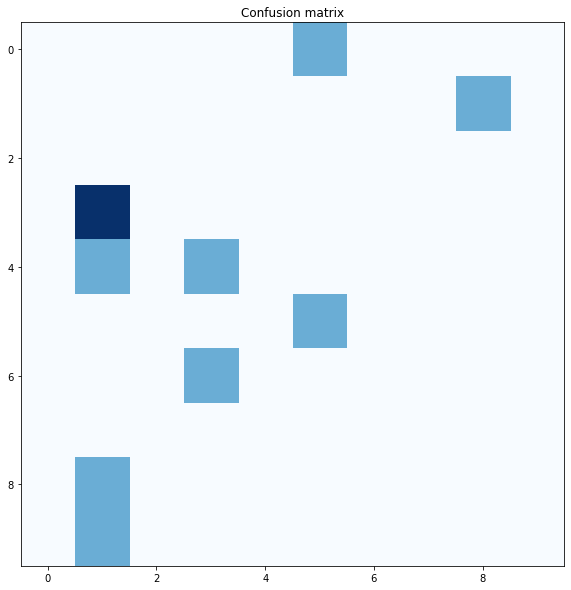

In [42]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))